# Tarea 5

__Alumno:__ Eduardo Carrasco

__Curso:__ Aprendizaje Automático 2022 

__Programa:__ DISC

__Profesor:__ Gonzalo A. Ruz

__Ayudante:__ Carlos Sepúlveda

**Tema**: Keras (Convolutional Neural Networks CNN) - aplicado a Flowers Recognition

## Instrucciones
* Por favor responder en este mismo notebook
* Renombrar el archivo agregando su nombre, por ejemplo tarea5_Lepe_Contreras.ipynb
* Subir el archivo al link de entrega Trabajo en webcursos que será habilitado
* __Fecha de entrega:__ viernes 04 de noviembre, 23:55 hrs.

In [1]:
#pip install tensorflow keras 

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('ignore')

## Librerias generales
import os
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
from glob import glob
from numpy import zeros, array, argmax, vstack
from sklearn.metrics import confusion_matrix, classification_report

## Keras tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam

# Keras - Layers for CNN
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dense
from tensorflow.keras.applications import VGG16

### Customized function

In [2]:
def plot_history(history, width=12, height=6):
  """
  DESCRIPTION:
    History performance of the keras model
  
  INPUT:
    @param history: history of performance of fitted model
    @type history: tensorflow.python.keras.callbacks.History

  OUTPUT:
    A graphic
  """

  ## Metrics keys stored in tensorflow object
  keys = list(history.history.keys())

  ## Number of epoch used for fit the model
  epoch = range(1, len(history.epoch) +1)

  ## Check if validation set was used.
  withValidation = False
  for key in keys:
    if 'val' in key:
      withValidation = True

  ## Number of metrics 
  nMetrics = len(keys)
  if withValidation:
    nMetrics = nMetrics//2

  ## Plot-space instance
  plt.figure(figsize=(width, height))

  for i in range(nMetrics):
    plt.subplot(nMetrics, 1, i+1)

    ## Plot (train) metric value
    labelMetric = keys[i]
    metric = history.history[keys[i]]
    plt.plot(epoch, metric, 'o-', label=labelMetric)

    if withValidation:
      ## Plot (validation) metric value
      labelMetricVal = keys[i+nMetrics]
      metricVal = history.history[keys[i+nMetrics]]
      plt.plot(epoch, metricVal, 'o-', label=labelMetricVal)

    plt.xlim(epoch[0], epoch[-1])
    plt.legend()
    plt.grid()
  plt.ylabel('Loss - Accuracy')
  plt.xlabel('Epoch')
  plt.title('Model Loss - Accuracy')
  plt.show()

**Data source:**

[Flowers classification](https://www.kaggle.com/alxmamaev/flowers-recognition) (Classification)

In [3]:
if not os.path.exists("dataFlowers.zip"): # bajar si no se encuentra presente
    
    ## Download files
    !wget https://github.com/adoc-box/Datasets/raw/main/flowers.zip #descarga de archivos
    !wget https://github.com/adoc-box/Datasets/raw/main/flowers.z01

    ## join files 
    !zip -F flowers.zip --out dataFlowers.zip

    ## remove some files
    !rm flowers.z01 flowers.zip

    ## un-compress joined zip file (descomprime)
    !unzip dataFlowers.zip
    
else:
    if os.path.exists('data'):
        !rm -r data
        !unzip dataFlowers.zip

Archive:  dataFlowers.zip
   creating: data/
   creating: data/test/
   creating: data/test/daisy/
  inflating: data/test/daisy/1140299375_3aa7024466.jpg  
  inflating: data/test/daisy/1354396826_2868631432_m.jpg  
  inflating: data/test/daisy/1355787476_32e9f2a30b.jpg  
  inflating: data/test/daisy/14147016029_8d3cf2414e.jpg  
  inflating: data/test/daisy/14272874304_47c0a46f5a.jpg  
  inflating: data/test/daisy/14307766919_fac3c37a6b_m.jpg  
  inflating: data/test/daisy/14332947164_9b13513c71_m.jpg  
  inflating: data/test/daisy/14333681205_a07c9f1752_m.jpg  
 extracting: data/test/daisy/14907815010_bff495449f.jpg  
  inflating: data/test/daisy/15306268004_4680ba95e1.jpg  
  inflating: data/test/daisy/16291797949_a1b1b7c2bd_n.jpg  
  inflating: data/test/daisy/16527403771_2391f137c4_n.jpg  
  inflating: data/test/daisy/18474740346_ffdaa18032.jpg  
  inflating: data/test/daisy/18901817451_43e2b45f6c.jpg  
  inflating: data/test/daisy/21402054779_759366efb0_n.jpg  
  inflating: data/te

## Muestras del dataset (train).

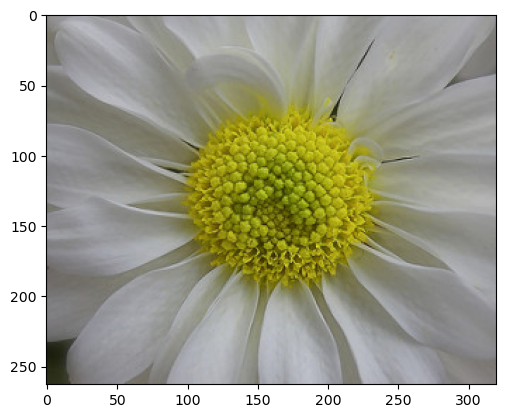

In [4]:
# Muestra de flor - Daisy
import matplotlib.pyplot as plt
plt.imshow(plt.imread('data/train/daisy/100080576_f52e8ee070_n.jpg'))

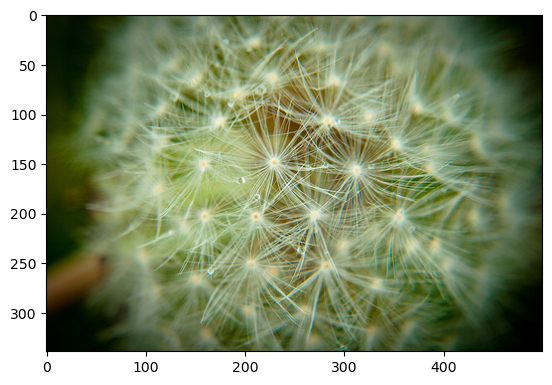

In [5]:
# Muestra de flor - Dandelion
import matplotlib.pyplot as plt
plt.imshow(plt.imread('data/train/dandelion/10437652486_aa86c14985.jpg'))

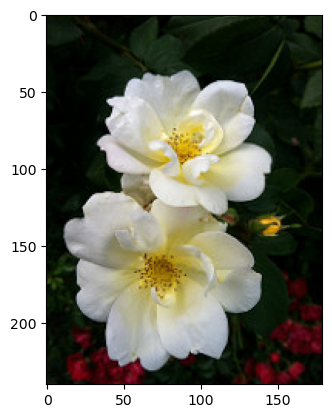

In [6]:
# Muestra de flor - Rose
import matplotlib.pyplot as plt
plt.imshow(plt.imread('data/train/rose/10090824183_d02c613f10_m.jpg'))

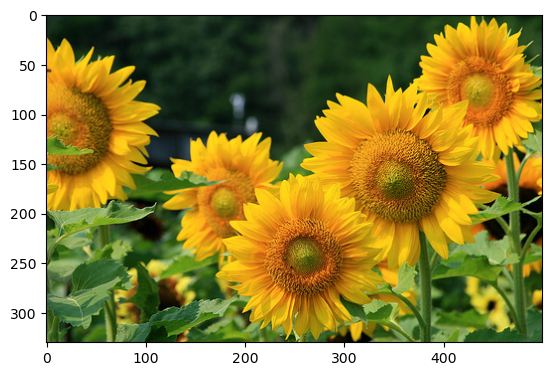

In [7]:
# Muestra de flor - Sunflower
import matplotlib.pyplot as plt
plt.imshow(plt.imread('data/train/sunflower/1008566138_6927679c8a.jpg'))

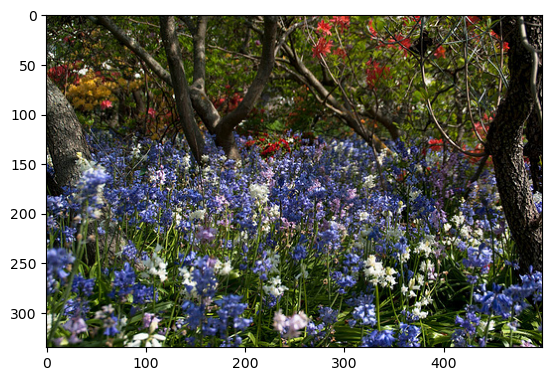

In [8]:
# Muestra de flor - Tulip
import matplotlib.pyplot as plt
plt.imshow(plt.imread('data/train/tulip/10094729603_eeca3f2cb6.jpg'))

### Image loader generator

In [9]:
## Images PATHs
train_dir = 'data/train/'
validation_dir = 'data/validation/'
test_dir = 'data/test/'

## Image generator instances
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

## Image conversion size
imgSize = 150

## Generator setting (Train)
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to (imgSize x imgSize)
        target_size=(imgSize, imgSize), 
        batch_size=20,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

## Generator setting (Validation)
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        # re-escalado (imgSize x imgSize)
        target_size=(imgSize, imgSize),
        batch_size=20,
        shuffle=False,
        # Label son categoricos
        class_mode='categorical')

## Generator setting (test)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        # re-escalado (imgSize x imgSize)
        target_size=(imgSize, imgSize),
        batch_size=20,
        shuffle=False,
        # Label son categoricos
        class_mode='categorical')

Found 2313 images belonging to 5 classes.
Found 554 images belonging to 5 classes.
Found 380 images belonging to 5 classes.


In [10]:
print(os.listdir('data/test')) # se verifica la cantidad de etiquetas de clasificación en test

['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']


In [11]:
print(os.listdir('data/train'))  # se verifica la cantidad de etiquetas de clasificación en train

['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']


In [12]:
print(os.listdir('data/validation'))  # se verifica la cantidad de etiquetas de clasificación en val

['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']


In [13]:
print(train_generator.image_shape)  # shape de imagen en train

(150, 150, 3)


In [14]:
print(validation_generator.image_shape)  # shape de imagen en val

(150, 150, 3)


In [15]:
print(test_generator.image_shape)  # shape de imagen en test

(150, 150, 3)


# __Actividad__

En base a lo aprendido en clase, genere un modelo de clasificación mediante redes neuronales convolucionales, para predecir el tipo de flor. Utilice el conjunto de entrenamiento y validación de la mejor forma tal de poder definir los hiperparámetros de una red neuronal convolucional (número de capas conv, número de filtros en las capas, tamaño de kernel, funciones de activación, pooling, número de épocas). Una vez que haya definido la mejor configuración de la red neuronal convolucional, evalúe el desempeño de esa red en el conjunto de prueba, en particular entregue el accuracy, precision, recall, y F1-score.

__Ayuda__: Rutina para extraer las etiquetas del generador de test. 

_Se usará esta función posterior al entrenamiento y validación_.

```python
## Reiniciar el generador al prier indice de la imagen
test_generator.reset()

## Extraer las etiquetas (codificadas en One-Hot) del conjunto de test.
i, y_true = 0, []
for _, y in test_generator:
    y_true.append(y)
    i+=1
    if i == 19:
      break
y_true = vstack(y_true)

## Decodificar las etiquetas
y_true = argmax(y_true, axis=1)
```

### Respuesta:

## Construcción del modelo:

In [17]:
## Propuesta primer modelo CNN

model = Sequential(name='FlowersClassification_1')

# 1ra Capa convolucional + Pooling.
model.add(Conv2D(filters = 16, kernel_size = (3,3), activation ='relu', 
                 input_shape = train_generator.image_shape))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# 2da Capa Convolucional + Pooling.
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# 3ra Capa Convolucional + Pooling.
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# 4ta Capa Convolucional + Pooling.
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Capa Aplanamiento.
model.add(Flatten())

# Capa densa - Salida.
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

model.summary()

Model: "FlowersClassification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17

In [19]:
#Selección de hiperparámetros será en manual.

start = time()
batch_size = 20
epochs = 50

## Compiling the Keras Model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fitting on the Training set and making predcitons on the Validation set
history = model.fit(
      train_generator,
      batch_size=batch_size,
      epochs=epochs, 
      steps_per_epoch= 116, # 2313 imagenes training (2313 / 20 - batch)
      validation_data=validation_generator,
      validation_steps=28, # 554 imagenes validation (554 / 20 - batch)
      verbose=1)

timeUp = time()-start
print('\nTime spent[s]: {:.2f}'.format(timeUp))

Epoch 1/50
  1/116 [..............................] - ETA: 30s - loss: 0.5684 - accuracy: 0.8000

2022-11-05 10:21:16.588426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


114/116 [============================>.] - ETA: 0s - loss: 0.7656 - accuracy: 0.7030

2022-11-05 10:21:19.681005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 4s 31ms/step - loss: 0.7651 - accuracy: 0.7030 - val_loss: 0.8596 - val_accuracy: 0.6733
Epoch 2/50
116/116 [==============================] - 3s 30ms/step - loss: 0.6562 - accuracy: 0.7601 - val_loss: 0.9342 - val_accuracy: 0.6408
Epoch 3/50
116/116 [==============================] - 3s 30ms/step - loss: 0.5045 - accuracy: 0.8154 - val_loss: 1.0053 - val_accuracy: 0.6534
Epoch 4/50
116/116 [==============================] - 4s 30ms/step - loss: 0.3903 - accuracy: 0.8612 - val_loss: 1.0824 - val_accuracy: 0.6570
Epoch 5/50
116/116 [==============================] - 4s 30ms/step - loss: 0.2681 - accuracy: 0.9014 - val_loss: 1.1891 - val_accuracy: 0.6480
Epoch 6/50
116/116 [==============================] - 4s 30ms/step - loss: 0.1766 - accuracy: 0.9438 - val_loss: 1.4708 - val_accuracy: 0.6462
Epoch 7/50
116/116 [==============================] - 4s 30ms/step - loss: 0.1663 - accuracy: 0.9434 - val_loss: 1.5072 - val_accuracy: 0.6570
Epoch 8/50

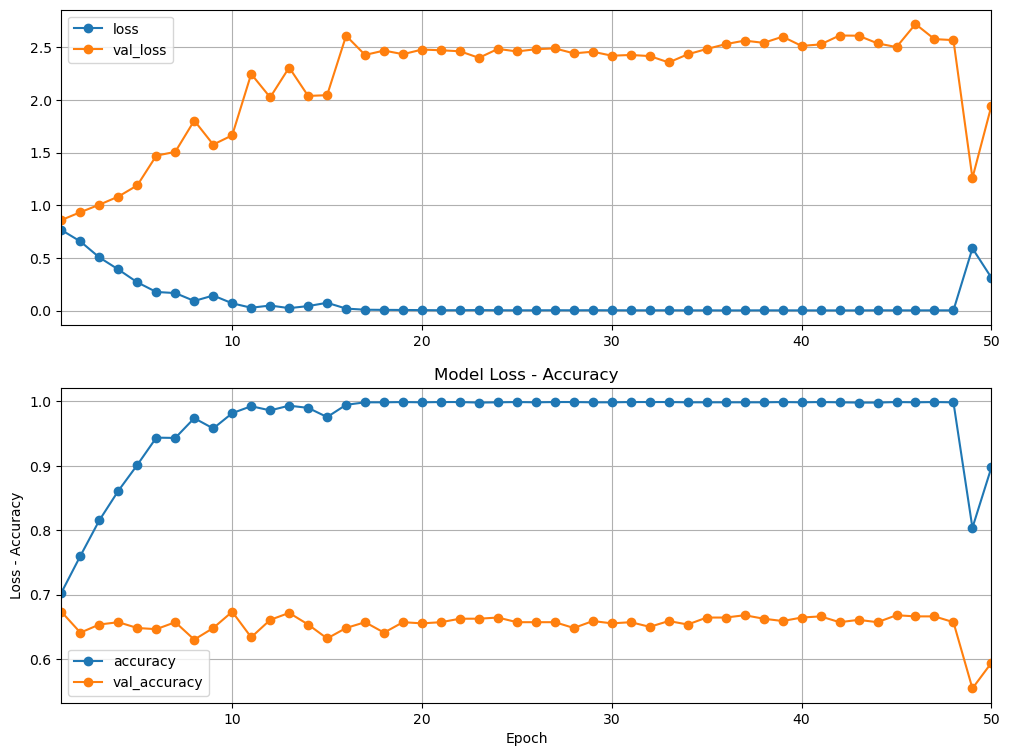

19/19 [==============================] - 1s 25ms/step - loss: 1.7523 - accuracy: 0.6105
[1.752253532409668, 0.6105263233184814]
 8/19 [===========>..................] - ETA: 0s

2022-11-05 10:24:28.473376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 0s 22ms/step


In [20]:
## Función history para obtener el gráfico de
# Val_loss y Val_accuracy
plot_history(history, width=12, height=9)

## restart test generator index
test_generator.reset()

## Evaluar el Test_generator en el modelo
print(model.evaluate(test_generator, 
                     steps=19))  ## <- 380 imagenes (380 / 20 - batch)

## restart test generator index
test_generator.reset()

## Compute prediction using test generator
prediction = model.predict(test_generator, steps=19)

Como se observa en la figura tanto del **Val_loss/loss** como del **val_accuracy/accuracy**, el número de épocas cercano a **6** presenta condiciones para prevenir el sobre entrenamiento.

In [21]:
## Reiniciar el generador al primer indice de la imagen
test_generator.reset()

## Extraer las etiquetas (codificadas en One-Hot) del conjunto de test.
i, y_true = 0, []
for _, y in test_generator:
    y_true.append(y)
    i+=1
    if i == 19:
      break
y_true = vstack(y_true)

## Decodificar las etiquetas
y_true = argmax(y_true, axis=1)
prediction_decoded = argmax(prediction, axis=1)

In [22]:
y_true.shape, prediction_decoded.shape

((380,), (380,))

In [23]:
## display confusion matrix
print(confusion_matrix(y_true=y_true, y_pred=prediction_decoded))

## display classification report
print(classification_report(y_true=y_true, y_pred=prediction_decoded))

[[45  6 15  3  1]
 [12 54  4 17  3]
 [ 8  3 40  0 19]
 [ 6  4  1 53  7]
 [ 9 10 20  0 40]]
              precision    recall  f1-score   support

           0       0.56      0.64      0.60        70
           1       0.70      0.60      0.65        90
           2       0.50      0.57      0.53        70
           3       0.73      0.75      0.74        71
           4       0.57      0.51      0.54        79

    accuracy                           0.61       380
   macro avg       0.61      0.61      0.61       380
weighted avg       0.62      0.61      0.61       380



Del resultado anterio, podemos concluir que el accuracy es bajo, al igual que el precision individual de cada clasificador. Se puede distinguir que el clasificador tiene mejor desempeño en Daisy y Sunflower. Es altamente probable que este mejor desempeño en términos de f1-score/precision se deban a la forma geométrica que es más distinguible que otras flores.

In [24]:
## Recomenzar todos los generators, objeto proponer un nuevo modelo.
train_generator.reset()
validation_generator.reset()
test_generator.reset()

## Propuesta de modelo:

Para el entrenamiento del modelo, se utilizarán las siguientes modificaciones:
- Kernel de la primera capa conv será de 5,5.
- Filter para la capa 1 conv sera de 32.
- Filter para la capa 2 conv sera de 64.
- Filters para las capas conv 3 y 4 será de 128.

Con estos hiperparámetros, se espera profundizar de mejor manera la red neuronal.

In [25]:
## Propuesta primer modelo CNN

model = Sequential(name='FlowersClassification_2')
# 1ra Capa convolucional + Pooling.
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu', 
                 input_shape = train_generator.image_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

# 2da Capa Convolucional + Pooling.
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# 3ra Capa Convolucional + Pooling.
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# 4ta Capa Convolucional + Pooling.
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Capa Aplanamiento.
model.add(Flatten())

# Capa densa - Salida.
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

model.summary()

Model: "FlowersClassification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 18, 18

De la experiencia anterior, se obtuvo que transcurrido un cierto número de épocas el modelo se sobreentrena, por lo cual, se decidió reducir a 6 épocas (análisis del gráfico anterior).

In [26]:
#Selección de hiperparámetros será en manual.

start = time()
batch_size = 20
epochs = 6

## Compiling the Keras Model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fitting on the Training set and making predcitons on the Validation set
history = model.fit(
      train_generator,
      batch_size=batch_size,
      epochs=epochs, 
      steps_per_epoch= 116, # 2313 imagenes training (2313 / 20 - batch)
      validation_data=validation_generator,
      validation_steps=28, # 554 imagenes validation (554 / 20 - batch)
      verbose=1)

timeUp = time()-start
print('\nTime spent[s]: {:.2f}'.format(timeUp))

Epoch 1/6


2022-11-05 10:24:59.138861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.3364 - accuracy: 0.4107

2022-11-05 10:25:04.689769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 6s 50ms/step - loss: 1.3364 - accuracy: 0.4107 - val_loss: 1.2174 - val_accuracy: 0.5126
Epoch 2/6
116/116 [==============================] - 6s 47ms/step - loss: 1.1267 - accuracy: 0.5305 - val_loss: 1.1152 - val_accuracy: 0.5487
Epoch 3/6
116/116 [==============================] - 6s 48ms/step - loss: 0.9851 - accuracy: 0.6169 - val_loss: 1.0518 - val_accuracy: 0.5812
Epoch 4/6
116/116 [==============================] - 5s 47ms/step - loss: 0.8524 - accuracy: 0.6697 - val_loss: 0.9889 - val_accuracy: 0.6209
Epoch 5/6
116/116 [==============================] - 5s 47ms/step - loss: 0.7038 - accuracy: 0.7294 - val_loss: 0.9679 - val_accuracy: 0.6390
Epoch 6/6
116/116 [==============================] - 5s 47ms/step - loss: 0.5746 - accuracy: 0.7812 - val_loss: 1.1505 - val_accuracy: 0.5957

Time spent[s]: 34.19


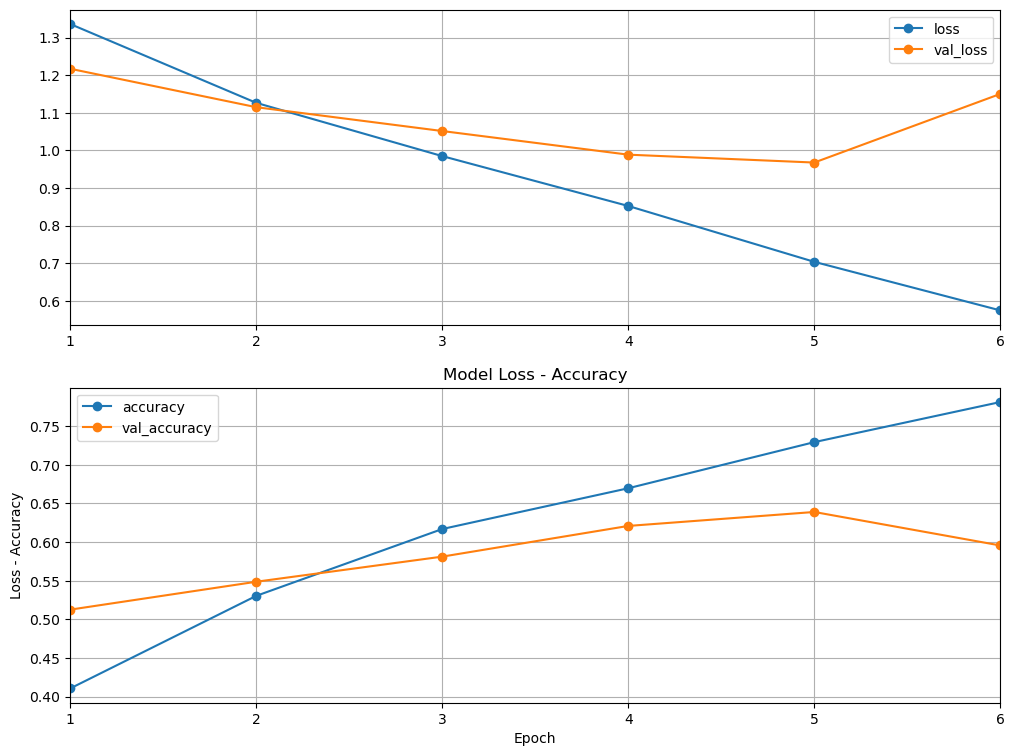

19/19 [==============================] - 1s 27ms/step - loss: 1.1507 - accuracy: 0.6263
[1.1507365703582764, 0.6263158321380615]
 7/19 [==========>...................] - ETA: 0s

2022-11-05 10:25:52.560378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 0s 23ms/step


In [27]:
## Función history para obtener el gráfico de
# Val_loss y Val_accuracy
plot_history(history, width=12, height=9)

## restart test generator index
test_generator.reset()

## Evaluar el Test_generator en el modelo
print(model.evaluate(test_generator, 
                     steps=19))  ## <- 380 imagenes (380 / 20 - batch)

## restart test generator index
test_generator.reset()

## Compute prediction using test generator
prediction = model.predict(test_generator, steps=19)

En este caso el número de épocas resulta ser tan reducido que no se puede distinguir cual es el valor óptimo.

In [28]:
## Reiniciar el generador al primer indice de la imagen
test_generator.reset()

## Extraer las etiquetas (codificadas en One-Hot) del conjunto de test.
i, y_true = 0, []
for _, y in test_generator:
    y_true.append(y)
    i+=1
    if i == 19:
      break
y_true = vstack(y_true)

## Decodificar las etiquetas
y_true = argmax(y_true, axis=1)
prediction_decoded = argmax(prediction, axis=1)

In [29]:
y_true.shape, prediction_decoded.shape

((380,), (380,))

In [30]:
## display confusion matrix
print(confusion_matrix(y_true=y_true, y_pred=prediction_decoded))

## display classification report
print(classification_report(y_true=y_true, y_pred=prediction_decoded))

[[48  3  9  5  5]
 [ 7 51 10 16  6]
 [ 4  2 38  0 26]
 [ 1  3  2 57  8]
 [ 7  5 20  3 44]]
              precision    recall  f1-score   support

           0       0.72      0.69      0.70        70
           1       0.80      0.57      0.66        90
           2       0.48      0.54      0.51        70
           3       0.70      0.80      0.75        71
           4       0.49      0.56      0.52        79

    accuracy                           0.63       380
   macro avg       0.64      0.63      0.63       380
weighted avg       0.64      0.63      0.63       380



El análisis del classification report menciona que el accuracy tiene una disminución general y sólo la primera clase tiene un aumento leve en su métrica de precision, por lo cual, no es un modelo óptimo.
A pesar de que la red neuronal es más profunda, la cantidad de épocas en la que se entrenó es muy corta, lo que no le permite optimizarse.